In [9]:
!pip install gym
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 11.4 MB/s eta 0:00:0000:0100:01
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 20.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.6/229.6 kB 27.4 MB/s eta 0:00:00


In [2]:
# import gym
# import numpy as np
# import random
# from tensorflow import keras
# from keras.models import Sequential
# from keras.layers import Dense, Flatten
# from keras.optimizers import Adam

In [3]:
# env = gym.make("CartPole-v1", render_mode="human")
# noOfStates = env.observation_space.shape[0]
# noOfActions = env.action_space.n

In [4]:
#@title Replay Memory Class
# class ReplayMemory:
#   def __init__(self,size):
#     self.size = size
#     self._memory = []
  
#   def add(self,value):
#     if len(self._memory) > 1000:
#       self._memory.pop(0) # Removing the outdated memory info
#     self._memory.append(value)
  
#   def length(self):
#     return len(self._memory)
  
#   def getAll(self):
#     # A Shallow copy is enough for this
#     # As all values here will be stored as tuples
#     return self._memory[::]

In [5]:
# #@title Neural Network Model
# def buildModel(noOfStates, noOfActions, learningRate):
#   model = Sequential([
#       Flatten(input_shape=(noOfStates)),
#       Dense(units = 24, activation = "relu"),
#       Dense(units = 24, activation = "relu"),
#       Dense(units = noOfActions, activation = "linear")
#   ])

#   model.compile(optimizer=Adam(learningRate = learningRate), loss="")

#   return model

In [6]:
# #@title Hyper Parameters

# maxEpsilon = 1
# minEpsilon = 0.01
# replayMemorySize = 1000
# batchSize = 16
# learningRate = 1e-4
# noOfEpisodes = 2000
# epsilonDecay = (minEpsilon/maxEpsilon)**(1/noOfEpisodes)
# epsilon = maxEpsilon

## DQN Algorithm
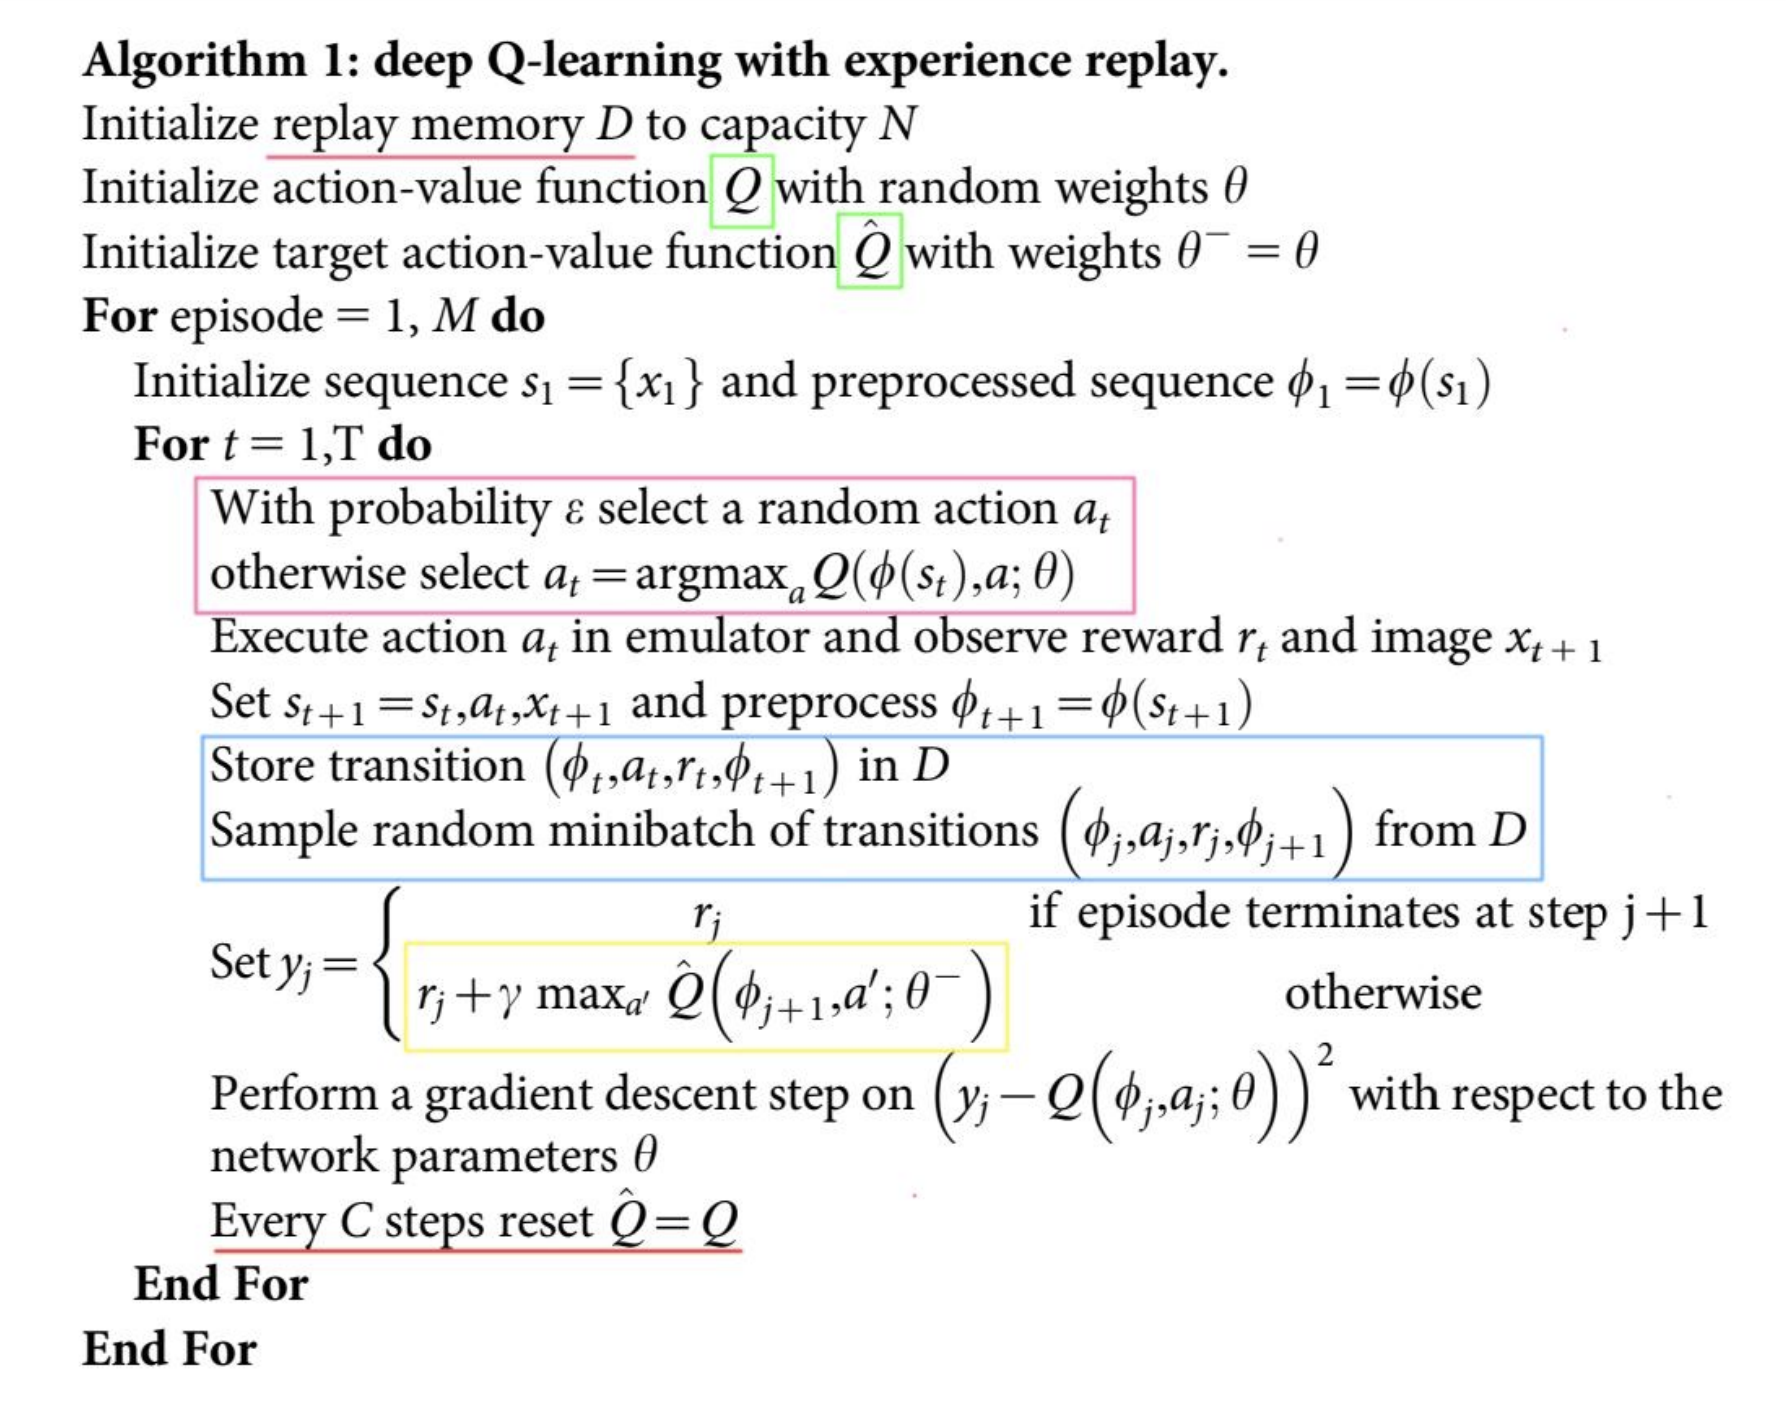

In [7]:
# #@title Algorithm Implementation
# # 1. Initialized Replay Memory
# replayMemory = ReplayMemory(replayMemorySize)
# # 2. Action value function with random weights
# trainingQFunction = buildModel(noOfStates, noOfActions, learningRate)
# # 3. Target Action Value function with the copy of the weights 
# targetQFunction = buildModel(noOfStates, noOfActions, learningRate)
# weights_theta = trainingQFunction.get_weights()
# targetQFunction.set_weights(weights_theta) 

# # 4. Outer For loop for episodes
# for episode in range(noOfEpisodes):
#   done = False
#   # 5.Initialized Sequence and preprocessed into numpy array
#   obs = np.array(env.reset())
#   total_rewards = 0

#   # 6. Inner loop for steps
#   while not done:
#     # 7. Exploration and Exploitation
#     randValue = np.random.rand()
#     action = None
#     if randValue < epsilon:
#       action = env.action_space.sample()
#     else :
#       action = np.argmax(trainingQFunction.predict(obs)[0])
#     action = np.array(action)
#     # 8. Executing action
#     nextObs, reward, done, info = env.step(action)
#     # 9. Preprocess observation
#     nextObs = np.array(nextObs)
#     total_rewards+= reward
#     # 10. Saving the value in memory
#     replayMemory.add((obs,action,reward,nextObs))
#     # 11. Sampling Random Minibatch
#     # We can modify this condition by changing threshold(batchSize) to higher
#     # value, so that the minibatch from the replay memory can be sampled
#     # from a larger pool of values
#     if replayMemory.length() > batchSize:
#       minibatch = np.array(random.sample(replayMemory.getAll(),batchSize))
      





#   epsilon *= epislonDecay



In [ ]:
# @title Revised DQN Implementation
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam
import tensorflow as tf

from collections import deque,namedtuple

Hyperparameters = namedtuple('Hyperparameters',[
    'memory_size'    ,
    'epsilon'        ,
    'epsilon_min'    ,
    'epsilon_decay'  ,
    'learning_rate'  ,
    'discount_factor',
    'batch_size'     ,
    'noOfEpisodes'   ,
    'stepsPerEpisode',
    'updateInterval' ,
])

class DeepQNetwork:
    def __init__(self, env, hyperparams):
        self.env = env
        self.replayMemory = deque(maxlen=hyperparams.memory_size)
        self.epsilon = hyperparams.epsilon
        self.epsilon_min = hyperparams.epsilon_min
        self.noOfEpisodes = hyperparams.noOfEpisodes
        self.stepsPerEpisode = hyperparams.stepsPerEpisode
        self.updateInterval = hyperparams.updateInterval
        self.epsilon_decay = 0.01
        self.learning_rate = hyperparams.learning_rate
        self.discount_factor = hyperparams.discount_factor
        self.batch_size = hyperparams.batch_size
        self.qNetwork = self.create_model()
        self.targetNetwork = self.create_model()
        self.syncWeights()

    def create_model(self):
        state_shape = self.env.observation_space.shape
        actions = self.env.action_space.n
        model = Sequential([
            Dense(24, input_dim=state_shape[0], activation="relu"),
            Dense(48, activation="relu"),
            Dense(24, activation="relu"),
            Dense(actions)
        ])
        model.compile(
            loss="mean_squared_error",
            optimizer=Adam(lr=self.learning_rate)
        )
        return model

    def syncWeights(self):
        weights = self.qNetwork.get_weights()
        self.targetNetwork.set_weights(weights)

    def getNextAction(self, state):
        epsilon = self.epsilon
        nextAction = None
        if np.random.random() < epsilon:
            nextAction = self.env.action_space.sample()
        nextAction = np.argmax(self.qNetwork.predict(state)[0])
        
        return nextAction

    def addToMemory(self, state, action, reward, nextState, done):
        self.replayMemory.append([state, action, reward, nextState, done])

    def predictValue(self):

        if len(self.replayMemory) < self.batch_size:
            return

        samples = random.sample(self.replayMemory, self.batch_size)
        for sample in samples:
            state, action, reward, nextState, done = sample
            target = self.targetNetwork.predict(state)
            if done:
                target[0][action] = reward
            else:
                nextQValue = max(self.targetNetwork.predict(nextState)[0])
                target[0][action] = reward + nextQValue * self.discount_factor
            self.qNetwork.fit(state, target, epochs=1, verbose=2)
    
    def train(self):
      env = self.env
      rewards = []
      noOfStates = env.observation_space.shape[0]
      print("-"*80)
      for episode in range(self.noOfEpisodes):
        print(f"{episode=}")
        print("-"*80)
        state = env.reset()
        state = np.array(state[0]).reshape(1,4)
        state = tf.convert_to_tensor(list(state))

        totalReward = 0
        for timestep in range(self.stepsPerEpisode):
          action = self.getNextAction(state)
          nextState, reward, done, truncated, info = env.step(action)
          nextState = np.array(nextState).reshape(1,4)
          nextState = tf.convert_to_tensor(nextState)

          self.addToMemory(state, action, reward, nextState,done)
          self.predictValue()
          totalReward += reward
          if timestep % self.updateInterval == 0:
            self.syncWeights()
        
          if done or totalReward > 500:
            break
          
        rewards.append(totalReward)
        print(f"{episode=},{totalReward}")
        print("-"*80)
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
      env.close()
      # Plot 1 : Episode vs Rewards
      plt.title(f'Rewards vs Steps of {env.spec.id}')
      plt.plot(list(range(self.noOfEpisodes)),rewards)
      plt.xlabel("Episodes")
      plt.ylabel("Rewards")
      plt.savefig(f'./RewardsVsEpisodes_{env.spec.id}.png')
      plt.show()

env = gym.make("CartPole-v1")

hyperparams = Hyperparameters(
    memory_size       = 1000,
    epsilon           = 1,
    epsilon_min       = 0.01,
    epsilon_decay     = 0.999,
    learning_rate     = 0.001,
    discount_factor   = 0.9,
    batch_size        = 16,
    noOfEpisodes      = 2000,
    stepsPerEpisode   = 100,
    updateInterval    = 5
)

dqn = DeepQNetwork(env, hyperparams)

dqn.train()



--------------------------------------------------------------------------------
episode=0
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 14ms/step
episode=0,10.0
--------------------------------------------------------------------------------
episode=1
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.5251 - 304ms/epoch - 304ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.5451 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.5092 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.5120 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.5487 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.5234 - 8ms/epoch 

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4951 - 8ms/epoch - 8ms/step
episode=1,8.0
--------------------------------------------------------------------------------
episode=2
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4934 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4904 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.4640 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4821 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4436 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4710 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4626 - 8ms/epoch - 8ms/step
1/1 [=================

1/1 - 0s - loss: 0.4726 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4637 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4420 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4301 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.4463 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.4761 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.4708 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.4615 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3422 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.4389 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s -

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4669 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2858 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4787 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2938 - 14ms/epoch - 14ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4908 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.4543 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.4940 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4568 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4436 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4829 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2288 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.4616 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.5009 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.4675 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4684 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.4800 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.4919 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4790 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.4460 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4539 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3825 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4037 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4081 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4126 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4023 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3822 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3807 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3716 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3894 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4069 - 19ms/epoch - 19ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4036 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.4089 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4151 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.4081 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1299 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.4202 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1301 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4062 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1223 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4139 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.4599 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0936 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.4523 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4302 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0932 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4351 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.4371 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4372 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0944 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4267 - 11ms/epoch - 11ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3657 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3649 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3500 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0547 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3696 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0616 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3473 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3584 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3515 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3616 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3979 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.4160 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3773 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3884 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3831 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3570 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3785 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3651 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3734 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.3703 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4285 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4170 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3944 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3963 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3998 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4054 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4012 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3882 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0115 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3780 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3427 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3323 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3168 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3039 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3125 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3130 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3095 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3200 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2982 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3014 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3359 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3388 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3515 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3494 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.3239 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3282 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.3467 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3246 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3262 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3231 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3697 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0116 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3483 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3420 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.3406 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3434 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3309 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0083 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3339 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3530 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3695 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3706 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3669 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.3628 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.3709 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3697 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3532 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3625 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0304 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3515 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2733 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2624 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.2643 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2669 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2819 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2592 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2602 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2598 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2675 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2525 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3419 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3337 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3236 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3096 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3408 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1299 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3121 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3153 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3288 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.3070 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.2281 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2373 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2378 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2137 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2259 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2300 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2360 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.2175 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2159 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2354 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2927 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2679 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2484 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2859 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2546 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3111 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2479 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3369 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3138 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3667 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2160 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2225 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2126 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2261 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2083 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2347 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2020 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2263 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2114 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2162 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3032 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2496 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2599 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2558 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2446 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2491 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2676 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2926 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2289 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2223 - 8ms/epoch - 8ms/step
episode=8,

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2302 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2757 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2591 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2381 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2184 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2448 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2132 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2451 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.7901 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2676 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2748 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2810 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2441 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2581 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3026 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.9352 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2467 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.9371 - 7ms/epoch - 7ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2711 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2499 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1705 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1777 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1443 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1423 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1856 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1578 - 8ms/epoch - 8ms/step
episode=9,10.0
--------------------------------------------------------------------------------
episode=10
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1550 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1789 - 9ms/epoch - 9ms/step
1/1 [===============

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1709 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1677 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1700 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 1.4598 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2150 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1735 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1775 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2010 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1636 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1576 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2007 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2883 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3150 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1875 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2924 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 1.7638 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2567 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1941 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1898 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2696 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1025 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1534 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0977 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0997 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 2.1289 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1118 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 2.1740 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2111 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 2.0457 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2282 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1767 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1758 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2219 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1047 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1916 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1115 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1057 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1833 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1172 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0933 - 10ms/epoch - 10ms/step
1/1 

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2462 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1749 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1688 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1556 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1999 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2246 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1459 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1966 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1234 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1499 - 10ms/epoch - 10ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1157 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1297 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0565 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1817 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2480 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1496 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2141 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2498 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 3.4659 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1569 - 11ms/epoch - 11ms/step
1/1 [===

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1881 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2115 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1261 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1067 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1181 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1072 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1007 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1387 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 3.7889 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.2453 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1620 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2194 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2097 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1452 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1588 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 3.7800 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2279 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2002 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1299 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1281 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 3.9494 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1306 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 4.0542 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1285 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1430 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2258 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.1095 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 4.0216 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1219 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1870 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0719 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0726 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0769 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0884 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0823 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 4.1989 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 4.2128 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1728 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1464 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2357 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 36ms/step
1/1 - 0s - loss: 0.0747 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0614 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1166 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0602 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0742 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0782 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0929 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1391 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0663 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 4.5204 - 8ms/epoch - 8ms/step
1/1 [=

1/1 - 0s - loss: 0.1665 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2409 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1316 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1080 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1506 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 4.7969 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1186 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1366 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0982 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1585 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s -

1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.2175 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1156 - 12ms/epoch - 12ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2274 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1391 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2226 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2185 - 13ms/epoch - 13ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1117 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1802 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0985 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1143 - 9ms/epoch - 9ms/step
1/1 [=

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1021 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1026 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0959 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1375 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0904 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1605 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 4.9109 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1058 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2229 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1118 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.1012 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1783 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0952 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1025 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0804 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2148 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0826 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 5.4379 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 19ms/step
1/1 - 0s - loss: 0.1034 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1536 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0845 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0649 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1270 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 5.8691 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1209 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0862 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1993 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0699 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0751 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0567 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 - 0s - loss: 0.0667 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1700 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1490 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0440 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0394 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0356 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0352 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1033 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1032 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0508 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s -

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0643 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0869 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1018 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0420 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0395 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0354 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1083 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0603 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0303 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0281 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1179 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0567 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1928 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0502 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0804 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0926 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0695 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0462 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1305 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.9556 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0891 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2242 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0699 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2289 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0550 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1784 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1813 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0803 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1078 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0823 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2563 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3284 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2098 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1667 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1597 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3401 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 6.9251 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2209 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2368 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1695 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2123 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1708 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1543 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1292 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0727 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1270 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1008 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0837 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0553 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0939 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1671 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1439 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1478 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1100 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.0986 - 12ms/epoch - 12ms/step
1/1 [==============================] - 0s 50ms/step
1/1 - 0s - loss: 6.8788 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 6.3018 - 13ms/epoch - 13ms/step
1/1 [==============================] - 0s 23ms/step
1/1 - 0s - loss: 0.1561 - 13ms/epoch - 13ms/step
1/1 [==============================] - 0s 20ms/step
1/1 - 0s - loss: 6.0294 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.1793 - 9ms/epoch - 9ms/step
1/

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0589 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0390 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0950 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.8518 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1212 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0596 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0811 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0947 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0460 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 6.7773 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0999 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1560 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1869 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2809 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0845 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0924 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1174 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1712 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0733 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0693 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1126 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1788 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1208 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1112 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0808 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1371 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0709 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0585 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1259 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1448 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2639 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1190 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2522 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1351 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.3698 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1520 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1684 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1286 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1282 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.6038 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.3414 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0994 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1123 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0921 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0916 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1034 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0913 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2177 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1332 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1190 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1445 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1704 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1017 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1640 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1114 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0901 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0881 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1253 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1001 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1379 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0717 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0564 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1519 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1153 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1399 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0461 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1653 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0528 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0348 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0530 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 - 0s - loss: 0.2200 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1867 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0757 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2180 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0884 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0488 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0550 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1028 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1111 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0574 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s -

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0642 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0739 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0979 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1136 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0765 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0618 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.8189 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 7.1311 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 6.8642 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1932 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.3579 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2218 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2365 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2554 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2743 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2184 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2279 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.4126 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2038 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2269 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0596 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1643 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0602 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0560 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1446 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0783 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0808 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.4836 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0813 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1236 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1375 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0927 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1154 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1604 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0876 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0912 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1680 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0710 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0628 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0617 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 23ms/step
1/1 - 0s - loss: 6.4794 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1300 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2817 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1246 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1257 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1001 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1016 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0951 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1401 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0969 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0735 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1704 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0520 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.0681 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1108 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0632 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1202 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0817 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0629 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0597 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0719 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1949 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1041 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0921 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0584 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0744 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0799 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0487 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0434 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.5614 - 9ms/epoch - 9ms/step
1/1 [===

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0227 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0621 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0632 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1223 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0532 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0440 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1346 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 7.9948 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 7.5097 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1468 - 8ms/epoch - 8ms/step
1/1 [=

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1345 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0921 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0428 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0446 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0534 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0647 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0413 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0431 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0378 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0253 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.7048 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2082 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.4946 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2910 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3272 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2423 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 7.3629 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4551 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4114 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3111 - 10ms/epoch - 10ms/step
1/1 [=

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0996 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1036 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2134 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2485 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0734 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1785 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.4801 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.2449 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.7824 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2000 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1721 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1512 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2208 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1482 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2886 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2467 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1565 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1079 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2285 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1090 - 8ms/epoch - 8ms/step
1/1 

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0389 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1995 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0501 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1657 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0901 - 8ms/epoch - 8ms/step
episode=25,9.0
--------------------------------------------------------------------------------
episode=26
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0313 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.8669 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0678 - 8ms/epoch - 8ms/step
1/1 [===============

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2389 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1284 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1268 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1123 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1786 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1945 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1520 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0783 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1252 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1096 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0890 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1228 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 8.8113 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1942 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2019 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1128 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0878 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0818 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.0977 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2140 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0915 - 9ms/epoch - 9ms/step
episode=26,10.0
--------------------------------------------------------------------------------
episode=27
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 8.6628 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1085 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1022 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0892 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0820 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 21ms/step
1/1 - 0s - loss: 0.1773 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1561 - 8ms/epoch - 8ms/step
1/1 [==============

1/1 - 0s - loss: 0.0708 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.0788 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0837 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0548 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0614 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0635 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0528 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1329 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.0386 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0373 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0592 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1338 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0319 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0782 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0553 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0228 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1123 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0241 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0327 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0236 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0170 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0438 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0804 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0176 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0201 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0542 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0231 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0258 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0149 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0176 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1935 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0599 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1222 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0449 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 9.9408 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.2248 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1713 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1017 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0814 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1554 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 25ms/step
1/1 - 0s - loss: 0.2355 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.2631 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2287 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.2957 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.1771 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2076 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 25ms/step
1/1 - 0s - loss: 0.1576 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.1691 - 12ms/epoch - 12ms/step
1/1 [==============================] - 0s 25ms/step
1/1 - 0s - loss: 0.2046 - 14ms/epoch - 14ms/step
1/1 [==============================] - 0s 32ms/step
1/1 - 0s - loss: 0.1497 - 24ms/epoch - 24ms/s

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0759 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1189 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0405 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0404 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0714 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0684 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0224 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.0236 - 20ms/epoch - 20ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0671 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 10.0168 - 10ms/epoch - 10ms/step
1/1 [

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0343 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.0057 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0357 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0053 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.0442 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0618 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0756 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0030 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0641 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 10.7361 - 9ms/epoch - 9ms/step
1/1

episode=29,9.0
--------------------------------------------------------------------------------
episode=30
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3047 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1589 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1682 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1826 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1401 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 9.9568 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4116 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2721 - 8ms/epoch - 8ms/step
1/1 [=============

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1158 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1354 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0995 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0917 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0794 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1202 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1247 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 9.2921 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1015 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2411 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3145 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2041 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2383 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1670 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2035 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.2365 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2768 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2976 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.8794 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2147 - 9ms/epoch - 9ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0982 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1194 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.3813 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1950 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1241 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1240 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2122 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1117 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1243 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1062 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1277 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1008 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2154 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1117 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1298 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1013 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0783 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0889 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0706 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 8.3273 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1226 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2375 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.8501 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.0516 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2953 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1933 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2370 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.2591 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2324 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.2153 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1210 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2158 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0718 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0989 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.6267 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1024 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1809 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0988 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1030 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1175 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0871 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.9928 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2487 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1560 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0521 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1758 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0506 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0701 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1202 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0389 - 9ms/epoch - 9ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0483 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0507 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.9728 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1021 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.0816 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0814 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0570 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0452 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0655 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0850 - 8ms/epoch - 8ms/step
1/1 

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.1591 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1449 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1584 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1282 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1414 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3088 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1444 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1255 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1358 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.1860 - 10ms/epoch - 10ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1223 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0812 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0596 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0482 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1859 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1516 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0366 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.6873 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0629 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0541 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2518 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0974 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0613 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.1037 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1034 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1041 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1079 - 8ms/epoch - 8ms/step
episode=33,9.0
--------------------------------------------------------------------------------
episode=34
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.4345 - 8ms/epoch - 8ms/step
1/1 [===============

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1962 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2683 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1586 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1387 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2189 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1074 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.8573 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1474 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1399 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1537 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1907 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1215 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1264 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1531 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0859 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1401 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1885 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0775 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0839 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0789 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0395 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0235 - 8ms/epoch - 8ms/step
episode=34,10.0
--------------------------------------------------------------------------------
episode=35
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0997 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.1277 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0529 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0676 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0530 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 7.6766 - 8ms/epoch - 8ms/step
1/1 [==============

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3241 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1843 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1685 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2126 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1406 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2290 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3181 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 6.7977 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1525 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2708 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1230 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0545 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0513 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0672 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0637 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1405 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.0390 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0560 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.8226 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.7233 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0734 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0628 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.0457 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0508 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0631 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0382 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0386 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0896 - 14ms/epoch - 14ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0861 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0315 - 8ms/epoch - 8ms/step
1/1 [=

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0350 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0332 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0181 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0236 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0189 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 21ms/step
1/1 - 0s - loss: 0.0154 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0216 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0437 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0869 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0241 - 8ms/epoch - 8ms/step
1/1 [=

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0612 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0542 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0792 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0503 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0661 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0553 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1317 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0413 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1105 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0614 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0938 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 19ms/step
1/1 - 0s - loss: 0.1345 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0877 - 14ms/epoch - 14ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0811 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0734 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2216 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0859 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0486 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0499 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1424 - 9ms/epoch - 9ms/step
1/1 [=

1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.2560 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3217 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3414 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2601 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2092 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1993 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2115 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1644 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1334 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.2627 - 8ms/epoch - 8ms/step
1/1 [=

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0800 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1147 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0688 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1122 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0808 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2907 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1535 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0485 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0702 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0602 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0715 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0656 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0722 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1542 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0465 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1885 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0437 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0565 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0381 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0660 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 - 0s - loss: 0.2731 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2464 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2758 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2169 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3339 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.0651 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2257 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 6.5003 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.4057 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.3780 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s -

1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1500 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1537 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2006 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 6.6368 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2307 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2182 - 19ms/epoch - 19ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1910 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1030 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.6023 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1264 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.3636 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1894 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2585 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1069 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1335 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1107 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1520 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 6.1507 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1166 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 19ms/step
1/1 - 0s - loss: 0.1306 - 8ms/epoch - 8ms/step
1/1 [=

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0359 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0356 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1130 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0660 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0683 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1849 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0323 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0409 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.0207 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0245 - 10ms/epoch - 10ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1240 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1199 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1049 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1111 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1121 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2364 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 19ms/step
1/1 - 0s - loss: 0.1572 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0975 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.9423 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1281 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0330 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 7.7821 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1289 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 7.4475 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1925 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1470 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1990 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0932 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0896 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1368 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0617 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0489 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0710 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0274 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0391 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1386 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0345 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0281 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0156 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0365 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.3321 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2819 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2805 - 7ms/epoch - 7ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.5110 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3173 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.2032 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2658 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4418 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2503 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2299 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1026 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1007 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.0184 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1141 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1292 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.0244 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1812 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1732 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1235 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1945 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0333 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0467 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0379 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1055 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1173 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0381 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0764 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0948 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1238 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0820 - 9ms/epoch - 9ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1119 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1234 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1354 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1929 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2437 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0873 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1287 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0849 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 7.5949 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1697 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0843 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1812 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1008 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0830 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0834 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1187 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2174 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0707 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1685 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1352 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1433 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0704 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0895 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1958 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1284 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0640 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1399 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0863 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0564 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0679 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 - 0s - loss: 0.1174 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1341 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1200 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.5412 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0878 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.0402 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1501 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.1991 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1551 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.3635 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s -

1/1 - 0s - loss: 0.1005 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0746 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 19ms/step
1/1 - 0s - loss: 0.1111 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0638 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1561 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1119 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0829 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1770 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0476 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0629 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s -

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2703 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1862 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1412 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1582 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1120 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1030 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0932 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1207 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1197 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0725 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0918 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0823 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0800 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1582 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1651 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.9766 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1633 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1705 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0937 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.6023 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1205 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0763 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0966 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0924 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0692 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0647 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.8377 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1218 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1139 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1129 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0662 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1032 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0296 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 9.5509 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0632 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0678 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0524 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1730 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0810 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 9.4766 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2068 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.8841 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 25ms/step
1/1 - 0s - loss: 0.2099 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 7.7636 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 19ms/step
1/1 - 0s - loss: 0.2434 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.2455 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3230 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2983 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1857 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3934 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.4487 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.4139 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.1958 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.4249 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3411 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3078 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.5700 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.1711 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.5519 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.2265 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1590 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1197 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1474 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1059 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1078 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1627 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2287 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0980 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 6.5681 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1129 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3183 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1161 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1222 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1448 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2264 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2137 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1506 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1103 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1014 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0791 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0859 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0795 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0795 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0580 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0634 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0617 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0716 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 6.6446 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1388 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1281 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0957 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0545 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0271 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 7.6182 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0440 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0791 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0536 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0498 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0841 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0635 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1136 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.2234 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0724 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.0668 - 14ms/epoch - 14ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.1390 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0822 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0514 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0725 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0808 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.8908 - 8ms/epoch - 8ms/step
1/1 

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2806 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2225 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2594 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2499 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2257 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 6.3682 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4215 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2987 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2899 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 6.4743 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2815 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0993 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 6.7300 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.5969 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2661 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1759 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1725 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1403 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2330 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 6.7392 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1783 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2919 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1326 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1173 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1195 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1726 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.1281 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1610 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2874 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1165 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1516 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1744 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 6.8597 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1040 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1160 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1406 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 6.8603 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1224 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1168 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1529 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0888 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0858 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0547 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0571 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1762 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0874 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0394 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.4776 - 7ms/epoch - 7ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0684 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0588 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1082 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1247 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1201 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1661 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1436 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0907 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1124 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1127 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0916 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1835 - 9ms/epoch - 9ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1993 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.3583 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3425 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1735 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 6.0280 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2462 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2736 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.2115 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2036 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1341 - 8ms/epoch - 8ms/step
1/1 [=

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0858 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0643 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0484 - 8ms/epoch - 8ms/step
episode=49,9.0
--------------------------------------------------------------------------------
episode=50
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0416 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0823 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0982 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0341 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0444 - 9ms/epoch - 9ms/step
1/1 [===============

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0532 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0457 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0353 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0359 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.0277 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0457 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0405 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 20ms/step
1/1 - 0s - loss: 0.1115 - 14ms/epoch - 14ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0734 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0203 - 10ms/epoch - 10ms/step


1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.1989 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0849 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0853 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.0184 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1415 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2761 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1285 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1581 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1659 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.9049 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1221 - 8ms/epoch - 8ms/step
episode=50,10.0
--------------------------------------------------------------------------------
episode=51
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1175 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.6524 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.4933 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.3386 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1655 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2147 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.3710 - 8ms/epoch - 8ms/step
1/1 [==============

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2136 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0465 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0710 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0555 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.0437 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0581 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0503 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0364 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1613 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0338 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0418 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0721 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 8.9299 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1894 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0751 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0752 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0607 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0829 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1229 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0537 - 10ms/epoch - 10ms/step
1/

1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.0504 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.7265 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2096 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.4643 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2752 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2730 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1923 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2284 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1115 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1236 - 10ms/epoch - 10ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1263 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1047 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0765 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0987 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1076 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.7531 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1745 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0950 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2401 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1483 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1435 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0822 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0786 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0546 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1422 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1742 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 9.1371 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 20ms/step
1/1 - 0s - loss: 0.0807 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.0844 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1025 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0760 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.6070 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1775 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.0615 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1256 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.7959 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2399 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2458 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.2721 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 21ms/step
1/1 - 0s - loss: 0.1708 - 9ms/epoch - 9ms/step
1/1 [===

1/1 [==============================] - 0s 24ms/step
1/1 - 0s - loss: 0.1573 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1775 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0912 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1072 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.8025 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1833 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 22ms/step
1/1 - 0s - loss: 0.1437 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.2385 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.2055 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0998 - 9ms/epoch - 9ms/step
1/1 

1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0430 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0418 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0740 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1302 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0422 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0426 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0350 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0314 - 15ms/epoch - 15ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0279 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0546 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0780 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1489 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0934 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1055 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0627 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0666 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0609 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.2018 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 8.7954 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1115 - 10ms/epoch - 10ms/step
1/1 [=

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2429 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0817 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0713 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0812 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1036 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2407 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0595 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0619 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0623 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 19ms/step
1/1 - 0s - loss: 9.0681 - 18ms/epoch - 18ms/step
1/1 [=

1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.1198 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0953 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0693 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0534 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0658 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0620 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.5124 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0821 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0911 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2114 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3137 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1685 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2447 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1312 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.8048 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1727 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.8475 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2094 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1998 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3650 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1947 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2512 - 7ms/epoch - 7ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2461 - 7ms/epoch - 7ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1499 - 7ms/epoch - 7ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1399 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1865 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1791 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1738 - 7ms/epoch - 7ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1142 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3025 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0831 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.7870 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1699 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0893 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1695 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1269 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0837 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2056 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2403 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0763 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1863 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3935 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1729 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1852 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1743 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1530 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.6287 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1607 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3118 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1626 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2242 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1036 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.2369 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.6723 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1210 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1198 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1097 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.9601 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2074 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1472 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1595 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1047 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1292 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0665 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0466 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0503 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.7650 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.2202 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1736 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1051 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0886 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1044 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0944 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1083 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1792 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.1566 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1723 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0997 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1295 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 8.4488 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0630 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0458 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0448 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1482 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0499 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0866 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0747 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0459 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.0400 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.7206 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0436 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0391 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0559 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0997 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1182 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0331 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0341 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0264 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0345 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.7909 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1371 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1041 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1150 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1064 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0998 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0898 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2208 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0829 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 7.9286 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 7.7743 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0783 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0667 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0954 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2243 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0638 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0525 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.9692 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0947 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0904 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0798 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2566 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0849 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.8249 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1662 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0740 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0676 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1925 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0677 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0934 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0554 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1254 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1206 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1076 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2322 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1225 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1657 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0976 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1266 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 25ms/step
1/1 - 0s - loss: 0.0789 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 7.6678 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0852 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1178 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.7357 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2071 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1307 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2577 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0857 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1788 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1622 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0633 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.6166 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0506 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0364 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0387 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0617 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0430 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0300 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0395 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0458 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1235 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2093 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2338 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2400 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.8827 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1560 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3017 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1087 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2198 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1421 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1442 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0532 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0561 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.8876 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0898 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0836 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0595 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1685 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 23ms/step
1/1 - 0s - loss: 0.1399 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1032 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1277 - 10ms/epoch - 10ms/step
1/1 [=

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1973 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2633 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2073 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2057 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1731 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1742 - 8ms/epoch - 8ms/step
episode=61,9.0
--------------------------------------------------------------------------------
episode=62
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1554 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1714 - 8ms/epoch - 8ms/step
1/1 [===============

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0800 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0983 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1315 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.8651 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0923 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0884 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1470 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2416 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.5794 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1728 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0896 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0586 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1196 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1639 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1068 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0876 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1225 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0840 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.9650 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0760 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2560 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1465 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2036 - 8ms/epoch - 8ms/step
episode=62,10.0
--------------------------------------------------------------------------------
episode=63
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1011 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1413 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0873 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0748 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0743 - 8ms/epoch - 8ms/step
1/1 [==============

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0629 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0706 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0672 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0567 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0515 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0483 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0474 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.4667 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0962 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0795 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1117 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0821 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0822 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1343 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0597 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1348 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2292 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0625 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0816 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0940 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.8062 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2019 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.2033 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3941 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2393 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2291 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2493 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2140 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4877 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1904 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2311 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1131 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0929 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1554 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1390 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0745 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.4490 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1133 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1036 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1147 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1365 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2214 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1750 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1638 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1207 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 6.6923 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1186 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2212 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2859 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1300 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0810 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0216 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0151 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.4839 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0642 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0272 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0315 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0265 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0826 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0333 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0119 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0176 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.4034 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0281 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0493 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0687 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0959 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0318 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0454 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0208 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0508 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1070 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1010 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1534 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0424 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0380 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0433 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0364 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0300 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0389 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 - 0s - loss: 0.1015 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0775 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2061 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2198 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0703 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0565 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0550 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2179 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.0815 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0646 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s -

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0994 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.4269 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1657 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1342 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1122 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2190 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1428 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1125 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1172 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1023 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0944 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1261 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.1125 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1578 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0947 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 23ms/step
1/1 - 0s - loss: 0.0885 - 20ms/epoch - 20ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1021 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1044 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2256 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0848 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 6.6178 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.5103 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.6561 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.3174 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1234 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 19ms/step
1/1 - 0s - loss: 0.1116 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 6.7478 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.1839 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1840 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1083 - 9ms/epoch - 9ms/step
1/

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0479 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0284 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.4700 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0556 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0627 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0659 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0549 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1232 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 19ms/step
1/1 - 0s - loss: 0.0829 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 19ms/step
1/1 - 0s - loss: 0.0426 - 9ms/epoch - 9ms/step
1/1 [===

1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1147 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0627 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.6552 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0610 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1703 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1727 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0698 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0508 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1074 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0549 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1229 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1266 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0814 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0989 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0792 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0868 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0698 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1065 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1414 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0727 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0880 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0817 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0945 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0900 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0748 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0853 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1355 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.4825 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1193 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2484 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3364 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1681 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2240 - 8ms/epoch - 8ms/step
episode=68,9.0
--------------------------------------------------------------------------------
episode=69
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1530 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1519 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.3139 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2127 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2121 - 8ms/epoch - 8ms/step
1/1 [=============

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0777 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1297 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1069 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.2112 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1623 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0524 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0795 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0907 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.7983 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0850 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0967 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0999 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.6361 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1740 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2033 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1068 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1397 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1543 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1131 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0898 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1609 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.1246 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.0889 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 6.9076 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.2532 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2106 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1855 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.3429 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1922 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1990 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1919 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1243 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 23ms/step
1/1 - 0s - loss: 0.1354 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1832 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1905 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 29ms/step
1/1 - 0s - loss: 0.1087 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.1071 - 12ms/epoch - 12ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.0928 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.1877 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0670 - 11ms/epoch - 11ms/step


1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0950 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0309 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0305 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0424 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0367 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0309 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 8.2829 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.9572 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 7.2542 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1040 - 8ms/epoch - 8ms/step
1/1 [=

1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.0657 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0841 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0923 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0853 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0600 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0639 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 7.8307 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.2630 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.1131 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0916 - 8ms/epoch - 8ms/step
1/

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2564 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.3057 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1855 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2556 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1691 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.3388 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2183 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2553 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1779 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.3228 - 9ms/epoch - 9ms/step
1/1 [===

1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1192 - 22ms/epoch - 22ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 8.0160 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.2581 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 7.0209 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 19ms/step
1/1 - 0s - loss: 0.1781 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.2025 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.2765 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.2046 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.1548 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.1673 - 8ms/epoch - 8ms/step
1/

1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0746 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0436 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0777 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0566 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1360 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0812 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0344 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0503 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0353 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0435 - 8ms/epoch - 8ms/step
1/

1/1 [==============================] - 0s 24ms/step
1/1 - 0s - loss: 0.0845 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0292 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.0256 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0784 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0845 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0660 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0741 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0747 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0681 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0716 - 9ms/epoch - 9ms/step
1/

1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1658 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2892 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2719 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1321 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.1014 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1907 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1965 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.7623 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2118 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.4170 - 8ms/epoch - 8ms/step
1/1 

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1461 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.1475 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.1143 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.2087 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1226 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1250 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.0962 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1004 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.2163 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.0813 - 9ms/epoch - 9ms/step
1/1 [===

1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0864 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1491 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2287 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.1039 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 21ms/step
1/1 - 0s - loss: 0.0728 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0630 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0839 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0599 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 8.1027 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.1679 - 13ms/epoch - 13ms/step


1/1 [==============================] - 0s 24ms/step
1/1 - 0s - loss: 0.1646 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1843 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1170 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.0366 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1389 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.1582 - 13ms/epoch - 13ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1477 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.1308 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2542 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 23ms/step
1/1 - 0s - loss: 0.1345 - 14ms/epoch - 14ms/step
1/1 

1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.0523 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 19ms/step
1/1 - 0s - loss: 8.8292 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1598 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 8.2119 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1524 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2912 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1149 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1148 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.0988 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0782 - 9ms/epoch - 9ms/step
1/1 

1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1148 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0561 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1685 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0844 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1599 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0724 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0667 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 9.4426 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0724 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2441 - 9ms/epoch - 9ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1532 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1621 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1864 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0781 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.0938 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0712 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 9.3483 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1140 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2159 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.1075 - 9ms/epoch - 9ms/step
1/1 [=

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0657 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2102 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0547 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.0664 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.0487 - 12ms/epoch - 12ms/step
1/1 [==============================] - 0s 19ms/step
1/1 - 0s - loss: 0.0863 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 21ms/step
1/1 - 0s - loss: 0.1493 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 9.4366 - 12ms/epoch - 12ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.1376 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0930 - 9ms/epoch - 9ms/ste

1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0772 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 9.0496 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1154 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.0773 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1397 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0714 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0703 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1815 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0781 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1293 - 9ms/epoch - 9ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3353 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 19ms/step
1/1 - 0s - loss: 0.1246 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1226 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1471 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2771 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1231 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1278 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1004 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1410 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1044 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1138 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1014 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0984 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.8096 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1347 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1309 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1846 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1153 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.5461 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2181 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.0325 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 9.5150 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0712 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0425 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0432 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0580 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0393 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0350 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0496 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0430 - 9ms/epoch - 9ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1221 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0990 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1329 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 9.0863 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1159 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1195 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.1173 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1980 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1304 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0921 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2355 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3174 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2162 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.0768 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3368 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3048 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2276 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3405 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2244 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3045 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1013 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0962 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 9.0288 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1131 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1113 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.4235 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1206 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1723 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1895 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.0940 - 9ms/epoch - 9ms/step
1/1 [===

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0817 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0676 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0769 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1671 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0534 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0996 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0586 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1243 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0496 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0509 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1001 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0990 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 9.4344 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1773 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1679 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.7275 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1422 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1782 - 14ms/epoch - 14ms/step
1/1 [==============================] - 0s 33ms/step
1/1 - 0s - loss: 0.1618 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 20ms/step
1/1 - 0s - loss: 0.2379 - 10ms/epoch - 10ms/step
1/1 

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1160 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0742 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0724 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1146 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1231 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1352 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0433 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 9.5039 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.0860 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.1357 - 9ms/epoch - 9ms/step
1/1 [=

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0771 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 9.8612 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1062 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 9.0614 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1172 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1294 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1943 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1270 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1014 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2413 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 - 0s - loss: 0.2064 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1310 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1031 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1346 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2917 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0940 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0651 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0745 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0570 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0516 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s -

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2511 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2352 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2754 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2447 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3666 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2161 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3550 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1816 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1443 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1378 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 - 0s - loss: 0.0962 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1064 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0364 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0358 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.6417 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 21ms/step
1/1 - 0s - loss: 0.0726 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0502 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1639 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0544 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1456 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0107 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0182 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1033 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2138 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0684 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 9.3835 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0786 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1094 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0842 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0723 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1160 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1293 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0560 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0689 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.0477 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0677 - 12ms/epoch - 12ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0490 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0709 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1564 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0668 - 9ms/epoch - 9ms/step
1/1 [=

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2450 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0973 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2548 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1075 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1231 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0823 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1479 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0670 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1131 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0988 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1489 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1181 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1094 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.8472 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1478 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0973 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1105 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1965 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0677 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1002 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2141 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2007 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1654 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3540 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2582 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.9886 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.4321 - 8ms/epoch - 8ms/step
episode=82,10.0
--------------------------------------------------------------------------------
episode=83
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2108 - 8ms/epoch - 8ms/step
1/1 [==============

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0689 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.7301 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1357 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.3639 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.6320 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2523 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1689 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1716 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.2216 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1437 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0973 - 12ms/epoch - 12ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0968 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1511 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0582 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1943 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1462 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0733 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0516 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0742 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0392 - 8ms/epoch - 8ms/step
1/1 [===

1/1 - 0s - loss: 8.1894 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.5040 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1181 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0826 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0908 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0749 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1341 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0836 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0696 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.4153 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s -

1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.0598 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0541 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.1255 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0525 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0467 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1326 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0971 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0770 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0531 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.6407 - 8ms/epoch - 8ms/step
1/1 [=

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0773 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.0521 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0679 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1709 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0768 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0415 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0438 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0579 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1151 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0434 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1104 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 21ms/step
1/1 - 0s - loss: 0.0552 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0375 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0527 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0343 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0286 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0531 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0334 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0176 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0188 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.7421 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2449 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0803 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0970 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1843 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0636 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1105 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1542 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0404 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1510 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 9.0423 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1100 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2140 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0665 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1440 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1067 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0781 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1320 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1227 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0688 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0893 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0785 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0813 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1415 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1052 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1333 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1524 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0688 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0521 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0524 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0752 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0748 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0870 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0504 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1916 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0851 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0884 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1918 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1510 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.7140 - 10ms/epoch - 10ms/step
1/1 [=

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0559 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1066 - 14ms/epoch - 14ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.0488 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0790 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 8.7327 - 7ms/epoch - 7ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1757 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1490 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0790 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0975 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0602 - 8ms/epoch - 8ms/step
1/1 

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2904 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1289 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.1998 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2319 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1312 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1110 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1269 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1058 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1870 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1223 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1890 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1939 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3270 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1908 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1265 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0961 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0649 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0765 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1166 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1538 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0979 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.3307 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0911 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1078 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2622 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0883 - 7ms/epoch - 7ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1125 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1468 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.9998 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1108 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0626 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1454 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1047 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0678 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0593 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1000 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0510 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0450 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0700 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0314 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0838 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1899 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1155 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.7486 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1139 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.2825 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2206 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1295 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1479 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1330 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.9182 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1642 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2299 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1717 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1697 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1823 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1316 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2064 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1750 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1253 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2024 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2792 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1836 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0890 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1035 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2133 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0999 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0959 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1346 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0924 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0699 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0761 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1081 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0611 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1560 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0662 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0559 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0495 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0486 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0588 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0988 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1333 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1490 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1883 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.3965 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1087 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1022 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0795 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1086 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0994 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0971 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.7722 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 7.2796 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 7.0445 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2082 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.8125 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2824 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.5821 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2691 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.3118 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1005 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1043 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0898 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.5741 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2414 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1341 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3231 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1109 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.0930 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1262 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1577 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1403 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1617 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1326 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1290 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1222 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1050 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0951 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1147 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0841 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1423 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1333 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.1725 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.9575 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2931 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 6.6130 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.3715 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1933 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1590 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1178 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0794 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0787 - 8ms/epoch - 8ms/step
episode=91,9.0
--------------------------------------------------------------------------------
episode=92
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0510 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0884 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1554 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0550 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.6457 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0741 - 8ms/epoch - 8ms/step
1/1 [===============

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1652 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1443 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 19ms/step
1/1 - 0s - loss: 0.2574 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1775 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.0964 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1491 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1471 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1276 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1485 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1658 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1976 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0991 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0867 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1697 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.8451 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0946 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1366 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.2152 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.0059 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2118 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1104 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1022 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.2138 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1127 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0766 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1190 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0754 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1012 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.2263 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1352 - 9ms/epoch - 9ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1296 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1606 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1464 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1677 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2181 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1616 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1202 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1868 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1092 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0913 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.0841 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.6335 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1514 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0996 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.5920 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1804 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2518 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1434 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1292 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1815 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0786 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0875 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0750 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1149 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.7571 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0927 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1598 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2420 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1721 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0909 - 7ms/epoch - 7ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1586 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1815 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1398 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1397 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1720 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1524 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1152 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1943 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1355 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1058 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0578 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0547 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0928 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0559 - 7ms/epoch - 7ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0521 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0488 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0564 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0725 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0994 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1655 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2109 - 7ms/epoch - 7ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 5.8766 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1421 - 7ms/epoch - 7ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1555 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1386 - 7ms/epoch - 7ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1571 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1924 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1696 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2054 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 6.0541 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1220 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1565 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1553 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1050 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1127 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0878 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0893 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1002 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0880 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1377 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1102 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1620 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0951 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0801 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 6.4846 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 5.9738 - 8ms/epoch - 8ms/step
episode=95,9.0
--------------------------------------------------------------------------------
episode=96
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 6.0372 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 5.7338 - 8ms/epoch - 8ms/step
1/1 [===============

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0800 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0678 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0748 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1583 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0697 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0529 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0837 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0454 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0629 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1338 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1218 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1151 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1325 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0978 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1359 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1883 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.2366 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1987 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1198 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0980 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1161 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1144 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1157 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1097 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1215 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.1333 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1776 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1203 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1885 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2377 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1589 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 6.2000 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 5.9702 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1413 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1361 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 5.9846 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1875 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 5.8801 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 31ms/step
1/1 - 0s - loss: 0.3371 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.2264 - 10ms/epoch - 10ms/step
1/1 

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0774 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1024 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0711 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1054 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0993 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1460 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0573 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0749 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.3750 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0891 - 9ms/epoch - 9ms/step
1/1 [===

1/1 - 0s - loss: 0.1031 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1931 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1000 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1060 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0937 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0989 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0875 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1053 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0931 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.4576 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s -

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0825 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 6.0313 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1486 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0890 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1536 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1310 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0821 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1836 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0822 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.0721 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0452 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.5195 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0692 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.3237 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.1382 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1942 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1278 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1544 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1190 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 20ms/step
1/1 - 0s - loss: 0.2378 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2012 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1205 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1833 - 20ms/epoch - 20ms/step
1/1 [==============================] - 0s 21ms/step
1/1 - 0s - loss: 6.3170 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2351 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.1522 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1393 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.5052 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1526 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 19ms/step
1/1 - 0s - loss: 0.1540 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0896 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.0770 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0711 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1002 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0597 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0734 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 7.1430 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1780 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1363 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0965 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0577 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0628 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0668 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.5668 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0797 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1801 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 7.2295 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1584 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1177 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 6.7631 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.9800 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1895 - 13ms/epoch - 13ms/step
1/1 [==============================] - 0s 23ms/step
1/1 - 0s - loss: 0.3860 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.3572 - 36ms/epoch - 36ms/step
1/1 [==============================] - 0s 19ms/step
1/1 - 0s - loss: 0.1630 - 12ms/epoch - 12ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.1378 - 12ms/epoch - 12ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1303 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.2625 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2960 - 7ms/epoch - 7ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.3443 - 10ms/epoch - 10ms/ste

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1835 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1076 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1196 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1096 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1245 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0948 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0847 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0822 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.3526 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.9694 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1056 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 23ms/step
1/1 - 0s - loss: 0.1343 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2381 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0995 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.2114 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1386 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1696 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.1810 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1324 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1279 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0840 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0682 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1335 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0684 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0743 - 12ms/epoch - 12ms/step
1/1 [==============================] - 0s 20ms/step
1/1 - 0s - loss: 0.0973 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0829 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0557 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 19ms/step
1/1 - 0s - loss: 0.1312 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1182 - 9ms/epoch - 9ms/step
1/1 [=

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0502 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0480 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0390 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0941 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0379 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0242 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0318 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0190 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0460 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0850 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1039 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0897 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1118 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0862 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0902 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0745 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0812 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0947 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0815 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0543 - 8ms/epoch - 8ms/step
1/1 

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1235 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1755 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1676 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0626 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0885 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1321 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0459 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0407 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0438 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0961 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0513 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0487 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2120 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.7798 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0571 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 8.5798 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1147 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1538 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1862 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1119 - 10ms/epoch - 10ms/step
1/1 [=

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0600 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0334 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0437 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0294 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0385 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0216 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0301 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0219 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0271 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 9.3152 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1528 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1173 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.4852 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1869 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.1900 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3876 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3028 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2081 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.9197 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2223 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3356 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3525 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3201 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3639 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.4313 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4040 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3206 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.5520 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1068 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.2610 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1039 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0669 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0986 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0436 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0512 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0535 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0493 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.7499 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0754 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0664 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0810 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0301 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0355 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0389 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0295 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0368 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0536 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0298 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0309 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.9159 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 - 0s - loss: 0.0760 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0761 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0825 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1290 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0742 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0730 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.2850 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.7289 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1284 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.3103 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s -

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0795 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0857 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0670 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0764 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.2892 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1546 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0897 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1203 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1040 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0957 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 21ms/step
1/1 - 0s - loss: 0.0820 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1635 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0427 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0311 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1481 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0793 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0452 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0287 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.0895 - 13ms/epoch - 13ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0269 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0737 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1093 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.9637 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0837 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0811 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0793 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1622 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1534 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0947 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0592 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1154 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0995 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0904 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.6945 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1453 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2325 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2538 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2031 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1207 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0904 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1124 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1050 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2427 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1477 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0672 - 8ms/epoch - 8ms/step
episode=106,9.0
--------------------------------------------------------------------------------
episode=107
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0761 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1017 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1729 - 8ms/epoch - 8ms/step
1/1 [=============

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0694 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0958 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0332 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0691 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0276 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0330 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0340 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0380 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0458 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0357 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0818 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2286 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1723 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0960 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1142 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1244 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0685 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1193 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0800 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0980 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3729 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3173 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2299 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.0543 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1465 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 19ms/step
1/1 - 0s - loss: 0.1162 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1289 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1594 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.9588 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1369 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1803 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1664 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 22ms/step
1/1 - 0s - loss: 7.4656 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2050 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1998 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2580 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1827 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1801 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1858 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1625 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 24ms/step
1/1 - 0s - loss: 0.0766 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0608 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0598 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0939 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0713 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1004 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0633 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0468 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0412 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0590 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1107 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.0888 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.8435 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1239 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1197 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0928 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0926 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1030 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1039 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1029 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0398 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0355 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0919 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0469 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0310 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0411 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0627 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0374 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0255 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0369 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0260 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1124 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0982 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0622 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0190 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0233 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0496 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0445 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0172 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0163 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0600 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0734 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.6871 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1486 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1091 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0970 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1297 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0846 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0929 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0708 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0707 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.7270 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.5297 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2059 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1919 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1388 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1585 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1486 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3141 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1842 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1530 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1753 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1409 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2433 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3083 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1720 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.6181 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2440 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.5895 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1894 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1006 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.1681 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.9531 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1519 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2155 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1387 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1339 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1588 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1481 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1638 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1461 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1060 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1070 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0877 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1271 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1418 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0774 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0796 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0549 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0710 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0175 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 9.6000 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0515 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0371 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0442 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0518 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0462 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0508 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0563 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0614 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 - 0s - loss: 9.0959 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1443 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1964 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0920 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0512 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1613 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 9.2331 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0937 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1318 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0694 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s -

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 9.7844 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0954 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1354 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1164 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1101 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1062 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0747 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0691 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0863 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 10.0046 - 8ms/epoch - 8ms/step
1/1 [====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0479 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0437 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0563 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0399 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0558 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0475 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0468 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0928 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1160 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0553 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3529 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.4137 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4254 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.6440 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4114 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3873 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.4145 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.3831 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3931 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.4012 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2510 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1666 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1756 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2609 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.8016 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1533 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.3404 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2712 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.2487 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3585 - 8ms/epoch - 8ms/step
episode=11

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.4791 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1673 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1621 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1556 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.5015 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3945 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1765 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1723 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2562 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2538 - 7ms/epoch - 7ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1864 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1596 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1355 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3133 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1414 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2692 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1620 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1423 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2022 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1285 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0678 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0407 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.6941 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0481 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0493 - 8ms/epoch - 8ms/step
episode=114,10.0
--------------------------------------------------------------------------------
episode=115
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.4254 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0768 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1510 - 8ms/epoch - 8ms/step
1/1 [============

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0867 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0453 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0392 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0755 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0496 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0662 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0231 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0204 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0201 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0298 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0908 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 7.4112 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.9520 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.7574 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 6.5591 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3824 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 6.5603 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.3144 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3738 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2565 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.6592 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.5994 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3591 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.4822 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4802 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3549 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.5137 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3270 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3436 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2943 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1660 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1088 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0908 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1697 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0671 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1082 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1700 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1504 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0561 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0743 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1422 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 21ms/step
1/1 - 0s - loss: 0.2208 - 7ms/epoch - 7ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1915 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1044 - 7ms/epoch - 7ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1447 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1872 - 7ms/epoch - 7ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2170 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1064 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1977 - 7ms/epoch - 7ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0804 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1031 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1801 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1139 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 6.9097 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2065 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1131 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1065 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1255 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2652 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1136 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1450 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0642 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1970 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0577 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1875 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 7.4895 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0961 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0734 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0715 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0804 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 22ms/step
1/1 - 0s - loss: 0.0686 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0548 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0727 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1469 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0881 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.1550 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0823 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.8107 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.2157 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1919 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 - 0s - loss: 0.1266 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.2134 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 29ms/step
1/1 - 0s - loss: 0.0822 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.1014 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0776 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1031 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0725 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1032 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1090 - 7ms/epoch - 7ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0876 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s -

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1535 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0828 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0877 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0935 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1532 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1078 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0745 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 20ms/step
1/1 - 0s - loss: 0.1787 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.0811 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 20ms/step
1/1 - 0s - loss: 0.0648 - 9ms/epoch - 9ms/step
1/1 [===

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0205 - 7ms/epoch - 7ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0547 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0634 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0441 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0200 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0255 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0287 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0227 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0572 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0305 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2175 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1901 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1296 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0893 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1406 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1412 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0996 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0944 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0754 - 12ms/epoch - 12ms/step
1/1 [==============================] - 0s 29ms/step
1/1 - 0s - loss: 8.2001 - 10ms/epoch - 10ms/step
1/1 [=

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1432 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1084 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1536 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1130 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1320 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2155 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0929 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.3797 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1310 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1180 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1631 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2972 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1599 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1338 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1605 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1910 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1900 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2015 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0983 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0867 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1026 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1344 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.5469 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1245 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1042 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1621 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0907 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0891 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1329 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1171 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2131 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1284 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.5170 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1686 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1825 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1958 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2077 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1656 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1542 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2020 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 - 0s - loss: 0.0415 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0392 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1029 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0367 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0613 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0765 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0877 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1065 - 7ms/epoch - 7ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1168 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0880 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s -

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2411 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1000 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1614 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2404 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1398 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0947 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.0594 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1272 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1289 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.9642 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1451 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1373 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1196 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1978 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1462 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1251 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0887 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.4777 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1724 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1406 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1877 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1462 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0976 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1047 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0963 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0797 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.1540 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1027 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1538 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0932 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1329 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.0352 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1106 - 7ms/epoch - 7ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2347 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0991 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1999 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2116 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2099 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0999 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.0028 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1517 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1302 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1413 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2087 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1553 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1671 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1814 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1150 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 20ms/step
1/1 - 0s - loss: 0.0949 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1232 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3021 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4505 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3444 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2613 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2423 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3040 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1979 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.2673 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3740 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2658 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0376 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0646 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0476 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0482 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0340 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2107 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2314 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0653 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0630 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.6617 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1075 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 19ms/step
1/1 - 0s - loss: 0.2254 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0807 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0824 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0825 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 19ms/step
1/1 - 0s - loss: 0.0605 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0716 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0551 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1152 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1418 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1020 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0868 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0795 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0736 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0975 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1239 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1240 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0870 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0999 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0504 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1195 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0787 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1133 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1490 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1225 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.1735 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1114 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0937 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1226 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1504 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1581 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.1040 - 7ms/epoch - 7ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1211 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1150 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1410 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1052 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0734 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0718 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0822 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.3392 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2177 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2143 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1565 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1963 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2436 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1309 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1499 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2936 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2093 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.1089 - 19ms/epoch - 19ms/step
1/1 [===

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0295 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0425 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0245 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0347 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0243 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0220 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0247 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0333 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0453 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 9.2514 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2176 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1006 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1546 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1101 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0867 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.4978 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2047 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.0645 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0963 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0902 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2436 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1281 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.7103 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2026 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2185 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1544 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3276 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1307 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2317 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1418 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 - 0s - loss: 0.3078 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2029 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2104 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2397 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2110 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1648 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2190 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2603 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2474 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2243 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s -

1/1 - 0s - loss: 0.0797 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0796 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0816 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.0936 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1711 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0785 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0851 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0734 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1925 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0994 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s -

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.2595 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0475 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0627 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0555 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0546 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0839 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1128 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0455 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.6072 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0738 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0706 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1556 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.2673 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1120 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.0734 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1658 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1069 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1101 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1145 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1042 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1030 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1018 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1567 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1711 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.2919 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1999 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.9055 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1255 - 13ms/epoch - 13ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1544 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1148 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2406 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2112 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1694 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1650 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1734 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2405 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2822 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2365 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.9702 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1914 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1355 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1091 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.7782 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1520 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1128 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2912 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0955 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 7.6488 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.5037 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.2564 - 15ms/epoch - 15ms/step
1/1 [===

1/1 [==============================] - 0s 20ms/step
1/1 - 0s - loss: 0.2361 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0886 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1995 - 7ms/epoch - 7ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0623 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1289 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.3283 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1669 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0967 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0968 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0926 - 10ms/epoch - 10ms/step
1/1 [===

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0600 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0613 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1226 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0971 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0631 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.7432 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2181 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1102 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1131 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1114 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 8.6928 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.1666 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1560 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.9772 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2013 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1972 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2906 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3036 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2726 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.0440 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2049 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2704 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1257 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2608 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1103 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1062 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1644 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1705 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1162 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1524 - 7ms/epoch - 7ms/step
1/1 [===

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1263 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1418 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1392 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1105 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1300 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1597 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.7032 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2562 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2294 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1241 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 - 0s - loss: 0.1313 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1120 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1108 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2588 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1142 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0914 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0879 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0829 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0964 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1489 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s -

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 9.3880 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.4625 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1369 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1340 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2655 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0918 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0800 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2209 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1743 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0842 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2358 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 23ms/step
1/1 - 0s - loss: 0.2384 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2333 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1668 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1692 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2959 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2172 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1496 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1150 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2033 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1010 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1096 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1705 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1151 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0791 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1352 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0690 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0635 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1535 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0686 - 8ms/epoch - 8ms/step
1/1 [=

1/1 [==============================] - 0s 21ms/step
1/1 - 0s - loss: 0.0930 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1303 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0889 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1394 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0852 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.9797 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1279 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.6895 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1373 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1608 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 - 0s - loss: 9.2795 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1156 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0853 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0946 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0802 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1224 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0896 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0915 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1307 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1365 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s -

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0870 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0835 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.8701 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1059 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.7024 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 8.3113 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.1971 - 12ms/epoch - 12ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.1856 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1770 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1827 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2797 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1113 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.2082 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1104 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1006 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1053 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0816 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2061 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0719 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0763 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.9687 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1164 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0799 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0815 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0721 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1188 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0694 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1537 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0607 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1795 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1760 - 16ms/epoch - 16ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1113 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1337 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1358 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1724 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1073 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0987 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1824 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1309 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1092 - 8ms/epoch - 8ms/step
1/1 

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1394 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0325 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1073 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0357 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0399 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0303 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0221 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 9.1774 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0587 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 21ms/step
1/1 - 0s - loss: 0.0534 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2390 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2532 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0886 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1047 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0896 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1665 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1605 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0887 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1943 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0815 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1038 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0920 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0720 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.2922 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1202 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2166 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.6071 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2190 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2155 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1729 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1517 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1092 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1797 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1061 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1022 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2364 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.0007 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1642 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.3241 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1146 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1085 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.0291 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.7548 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1498 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1362 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1723 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1636 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2403 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1210 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1825 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1057 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0854 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1204 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0880 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1447 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0704 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 8.3010 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 7.8247 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 19ms/step
1/1 - 0s - loss: 0.2300 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1042 - 8ms/epoch - 8ms/step
1/1 

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0960 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1115 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0997 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2223 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0739 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 7.8555 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1691 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1233 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0965 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0930 - 8ms/epoch - 8ms/step
1/1 [===

1/1 - 0s - loss: 8.3088 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0656 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0653 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0803 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0611 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0481 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0501 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1418 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0934 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0708 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s -

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0354 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0393 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0315 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0201 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0283 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0369 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0276 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0776 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1605 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1289 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0673 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0619 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1584 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0631 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0993 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0501 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1173 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0527 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.8472 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0967 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0331 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0210 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0119 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0658 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0349 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0158 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 9.3981 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0318 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.0436 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0293 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.4344 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1107 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0799 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0641 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0828 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1362 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 20ms/step
1/1 - 0s - loss: 0.1040 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0806 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1180 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.4650 - 8ms/epoch - 8ms/step
1/1 [=

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1186 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.7819 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2008 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.5176 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2543 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2269 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4639 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.2412 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.1785 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1524 - 9ms/epoch - 9ms/step
1/1 [===

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0482 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0359 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0769 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0659 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.0511 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1156 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0717 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0579 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0967 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.0857 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0676 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.0658 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.1930 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1125 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2523 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1533 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.2797 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1387 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1238 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1523 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.6173 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0988 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1084 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0917 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2083 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1807 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0835 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.3259 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0986 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1076 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.1913 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1332 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0939 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0802 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 19ms/step
1/1 - 0s - loss: 0.1551 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0800 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0949 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1112 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0897 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0619 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.2248 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1784 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.2165 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0700 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0703 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0709 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0755 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0680 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1742 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0677 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2385 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2142 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1733 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.2415 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.1571 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.2038 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1638 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1243 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1293 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1767 - 8ms/epoch - 8ms/step
1/1 [=

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2460 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1600 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1455 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1698 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2169 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1656 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2340 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1976 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1286 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1300 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0515 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1247 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0567 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0492 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.7346 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0659 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0723 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0617 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0703 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0582 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0441 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1135 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0419 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0835 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0590 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0966 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0536 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0837 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0883 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1178 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2225 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1916 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1555 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0851 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1450 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0746 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2131 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.4419 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.0722 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1832 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0493 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0638 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0714 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0587 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.5764 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0545 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0538 - 8ms/epoch - 8ms/step
episode=142,9.0
--------------------------------------------------------------------------------
episode=143
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0746 - 8ms/epoch - 8ms/step
1/1 [===========

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2692 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1229 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1790 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2132 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.5772 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3456 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1932 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1337 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1273 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3257 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0866 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0881 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1115 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1735 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0931 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.3148 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1178 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1306 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2058 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1464 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0292 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0392 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1037 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0157 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0344 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2492 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.0765 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0897 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0639 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.1758 - 13ms/epoch - 13ms/step
1/1 [===

1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0657 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0586 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0658 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0784 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1039 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0612 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0458 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1108 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0444 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1470 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0384 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1144 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0303 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1046 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0566 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0248 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0550 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0506 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0893 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0967 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1466 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0322 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 10.1086 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 10.1163 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1935 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1318 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 9.8602 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2132 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1370 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 9.4669 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 10.1077 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2371 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1470 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0925 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0689 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2073 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0774 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0675 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0565 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.0539 - 8ms/epoch - 8ms/step
1/1 [====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0561 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 9.9485 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 10.2070 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1604 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1729 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1569 - 8ms/epoch - 8ms/step
episode=145,9.0
--------------------------------------------------------------------------------
episode=146
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 9.6890 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.3152 - 8ms/epoch - 8ms/step
1/1 [============

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0746 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1553 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0456 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0396 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0454 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0359 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0367 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0214 - 12ms/epoch - 12ms/step
1/1 [==============================] - 0s 23ms/step
1/1 - 0s - loss: 0.0515 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 24ms/step
1/1 - 0s - loss: 0.1121 - 9ms/epoch - 9ms/step
1/1 [=

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0460 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0898 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0571 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0521 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1111 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0427 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0605 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1037 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1080 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0263 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 9.0682 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1577 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1734 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0911 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0835 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0750 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0613 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0743 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1466 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.3734 - 9ms/epoch - 9ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0932 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0764 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0820 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0655 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0930 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1159 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1857 - 13ms/epoch - 13ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.0652 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0992 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.6214 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1649 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1670 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 18ms/step
1/1 - 0s - loss: 0.2464 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1529 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2442 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2398 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1847 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1055 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1632 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.0563 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1320 - 10ms/epoch - 10ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1108 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2026 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1086 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1074 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0890 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0866 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0987 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1724 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1125 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1708 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.0869 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2178 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 23ms/step
1/1 - 0s - loss: 0.1291 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0867 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1144 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1833 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0957 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0629 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1102 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0883 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.7035 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1413 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1521 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1253 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1607 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0944 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0712 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0783 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0699 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0798 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1258 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1327 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1196 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0528 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0414 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0543 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0355 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0707 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0369 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0779 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0604 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1374 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1527 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0887 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0631 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0621 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0935 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0483 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0544 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1911 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0523 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0893 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0415 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 9.9553 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0817 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 9.5687 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1203 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 9.2111 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2165 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0429 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 9.2632 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0739 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0731 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1390 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0815 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 9.2067 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1120 - 16ms/epoch - 16ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0925 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1440 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0894 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1194 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.7532 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1819 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2528 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1251 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1387 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0929 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0924 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 9.0764 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2613 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2493 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1456 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2777 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1774 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2558 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1350 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0980 - 8ms/epoch - 8ms/step
episode=150,9.0
--------------------------------------------------------------------------------
episode=151
--------------------------------------------------------------------------------
1/1 [=============

1/1 - 0s - loss: 0.2416 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1145 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.1106 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2237 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1275 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.1324 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1130 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 8.1458 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1440 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1417 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s -

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1211 - 11ms/epoch - 11ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1137 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1432 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2243 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0844 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1085 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1576 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1013 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0653 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1782 - 8ms/epoch - 8ms/step
1/1 [===

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0979 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2425 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0828 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0656 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1695 - 8ms/epoch - 8ms/step
episode=151,10.0
--------------------------------------------------------------------------------
episode=152
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0685 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1695 - 13ms/epoch - 13ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0910 - 8ms/epoch - 8ms/step
1/1 [==========

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0861 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1234 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0354 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0534 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0297 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0295 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.0377 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1202 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0339 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0501 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0860 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1043 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0753 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0701 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 9.0008 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2629 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1153 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2314 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1070 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0836 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 - 0s - loss: 0.0927 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1160 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.0861 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0607 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1189 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 9.1882 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 9.1099 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.2159 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1373 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1286 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s -

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1949 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1434 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1120 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 15ms/step
1/1 - 0s - loss: 0.3082 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1218 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1412 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1367 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1213 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 9.0158 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1518 - 8ms/epoch - 8ms/step
1/1 [=====

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0918 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1734 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 8.6047 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1205 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.1471 - 8ms/epoch - 8ms/step
episode=153,9.0
--------------------------------------------------------------------------------
episode=154
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1290 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1047 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2257 - 8ms/epoch - 8ms/step
1/1 [=============

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.4238 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 7.4864 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 7.1199 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.5860 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2953 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 17ms/step
1/1 - 0s - loss: 0.3205 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 0.4913 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2938 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2684 - 14ms/epoch - 14ms/step
1/1 [==============================] - 0s 20ms/step
1/1 - 0s - loss: 0.2601 - 9ms/epoch - 9ms/step
1/1 [===

1/1 [==============================] - 0s 16ms/step
1/1 - 0s - loss: 0.1953 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.2210 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0935 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0707 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.0819 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 20ms/step
1/1 - 0s - loss: 8.2566 - 9ms/epoch - 9ms/step
1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 0.1782 - 8ms/epoch - 8ms/step
1/1 [==============================] - 0s 26ms/step
1/1 - 0s - loss: 0.2220 - 13ms/epoch - 13ms/step
1/1 [==============================] - 0s 48ms/step
1/1 - 0s - loss: 0.0993 - 21ms/epoch - 21ms/step
1/1 [==============================] - 0s 25ms/step
1/1 - 0s - loss: 0.1008 - 10ms/epoch - 10ms/step
1/1 